###### Imports

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
import gudhi as gd  
import random
import math
import tmd
import os
import cv2
from tmd.view import plot as tmdplt
from tmd.Topology import analysis
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
plt.style.use(['seaborn-white'])

###### General variables

In [12]:
data_path = 'Cortical_morphologies'
class1 = 'L4_SSC'
class2 = 'L4_TPC'
class3 = 'L4_UPC'
list_cells_C1 = os.listdir(data_path + '/' + class1)
list_cells_C2 = os.listdir(data_path + '/' + class2)
list_cells_C3 = os.listdir(data_path + '/' + class3)
classes = [class1, class2, class3]
all_files = [list_cells_C1, list_cells_C2, list_cells_C3]

###### Loading

In [29]:
all_neurons = {'A' : [], 'B' : [], 'C' : []}
# Load neurons for each class
for k, key in enumerate(all_neurons.keys()):
    print('Loading neuron class %s'%key)
    for file in all_files[k]:
        filename = data_path + '/' + classes[k] + '/' + file
        # Loading morphology --> We are taking only the axon
        all_neurons[key].append(tmd.io.load_neuron_from_morphio(filename).axon[0])

Loading neuron class A
Loading neuron class B
Loading neuron class C


###### Computing persistent homology features

In [32]:
PH = {}
for morpho_class in all_neurons.keys():
    PH[morpho_class] = []
    for neuron_tree in all_neurons[morpho_class]:
        PH[morpho_class].append(tmd.methods.get_persistence_diagram(neuron_tree, feature = 'radial_distances'))

###### Getting persistent images

In [37]:
Pers_images = {}
for morpho_class in PH.keys():
    Pers_images[morpho_class] = []
    for neuron_ph in PH[morpho_class]:
        Pers_images[morpho_class].append(analysis.get_persistence_image_data(neuron_ph))

###### Loading the model for features extractionr and restructuring (reshaping) images

In [56]:
# load model
model = VGG16()
# remove the output layer (we do not need to perform ImageNet classification)
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467904/553467096 [==============================] - 113s 0us/step


In [70]:
# We resize the persistent images to the size required by VGG16
resized_Pers_images = {}
for morpho_class in Pers_images.keys():
    resized_Pers_images[morpho_class] = []
    for image in Pers_images[morpho_class]:
        res_image = cv2.resize(image, dsize = (224, 224), interpolation = cv2.INTER_CUBIC)
        res_image_3D = np.repeat(np.expand_dims(res_image, axis = -1), 3, axis = -1)
        resized_Pers_images[morpho_class].append(res_image_3D)

###### Extracting features from persistent images

In [73]:
features = {}
for morpho_class in resized_Pers_images.keys():
    features[morpho_class] = []
    for image in resized_Pers_images[morpho_class]:
        tmp_image = image.reshape(1,*image.shape)
        features[morpho_class].append(model.predict(tmp_image))

###### Building final features matrix

In [81]:
all_vals = []
all_labels = []
for morpho_class in features.keys():
    features_tmp = np.squeeze(features[morpho_class])
    n_samples = np.shape(features_tmp)[0]
    all_vals.append(features_tmp)
    all_labels.append([morpho_class]*n_samples)
    print('There are %d samples for class %s'%(n_samples, morpho_class))
all_vals = np.concatenate(all_vals, axis = 0)
all_labels = np.concatenate(all_labels)
print('\nFinal shape features matrix :', all_vals.shape)

There are 10 samples for class A
There are 10 samples for class B
There are 10 samples for class C

Final shape features matrix : (30, 4096)


###### Applying dimensionality reduction

In [86]:
pca = PCA()
PCAed_data = pca.fit_transform(all_vals)
print('\nShape features matrix after PCA:', PCAed_data.shape)


Shape features matrix after PCA: (30, 30)


In [95]:
np.sum(pca.explained_variance_)

0.73661757

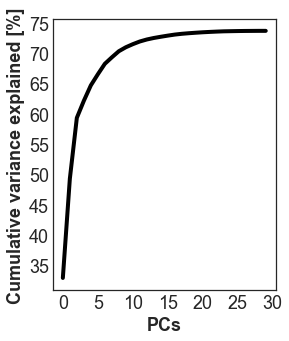

In [96]:
plt.figure(figsize = (4,5))
plt.plot(np.cumsum(pca.explained_variance_*100), color = 'black', lw = 4)
plt.xlabel('PCs', fontsize = 18, weight = 'bold')
plt.ylabel('Cumulative variance explained [%]', fontsize = 18, weight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [106]:
class1_idx = np.where(all_labels == 'A')[0]
class2_idx = np.where(all_labels == 'B')[0]
class3_idx = np.where(all_labels == 'C')[0]

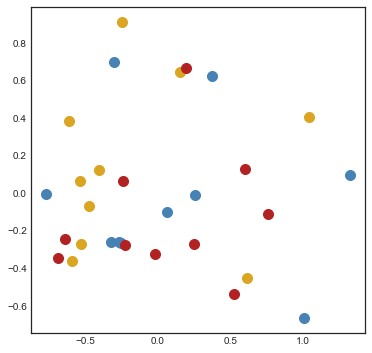

In [111]:
plt.figure(figsize = (6,6))
plt.scatter(PCAed_data[class1_idx,0], PCAed_data[class1_idx,1], color = 'goldenrod', s = 100)
plt.scatter(PCAed_data[class2_idx,0], PCAed_data[class2_idx,1], color = 'steelblue', s = 100)
plt.scatter(PCAed_data[class3_idx,0], PCAed_data[class3_idx,1], color = 'firebrick', s = 100)
plt.show()